In [2]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import joblib

In [5]:
# Load dataset 
df = pd.read_csv('C:/KULIAH/SEMESTER 3/Machine Learning/UAS/DATASET/1A.tsv', sep='\t')
df.head()

,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


In [6]:
# A). Exploratory Data Anaylysis
# 1. Check Data type, missing values, and distribution data 
eda_summary = {
    "Data Types": df.dtypes,
    "Missing Values": df.isnull().sum(),
    "Unique Values": df.nunique()
}

# Statistik deskriptif untuk kolom numerik
numeric_summary = df.describe()

# Distribusi variabel target (Stage)
stage_distribution = df['Stage'].value_counts()

eda_summary, numeric_summary, stage_distribution

({'Data Types': ID                             int64
  Registration Date             object
  Drug                          object
  Birth Date                    object
  Gender                        object
  Ascites                       object
  Hepatomegaly                  object
  Edema                         object
  Bilirubin                    float64
  Cholesterol                  float64
  Albumin                      float64
  Copper                       float64
  Alkaline Phospatase (U/L)    float64
  SGOT                         float64
  Tryglicerides                float64
  Platelets                    float64
  Prothrombin                  float64
  Stage                         object
  dtype: object,
  'Missing Values': ID                             0
  Registration Date              0
  Drug                         106
  Birth Date                     0
  Gender                         0
  Ascites                      106
  Hepatomegaly                 106
  Ed

### Variabel dalam Dataset
- **`ID`**: Identifikasi unik pasien.
- **`Registration Date`**: Tanggal pendaftaran pasien di rumah sakit.
- **`Drug`**: Jenis obat yang diberikan kepada pasien (D-penicillamine atau placebo).
- **`Birth Date`**: Tanggal lahir pasien.
- **`Gender`**: Jenis kelamin pasien.
- **`Ascites`**: Kehadiran ascites (Y/N).
- **`Hepatomegaly`**: Kehadiran hepatomegaly (Y/N).
- **`Edema`**: Kehadiran edema (N = tidak ada edema, S = edema tanpa diuretik, Y = edema meskipun dengan terapi diuretik).
- **`Bilirubin`**: Kadar bilirubin serum (mg/dL).
- **`Cholesterol`**: Kadar kolesterol serum (mg/dL).
- **`Albumin`**: Jumlah albumin (g/dL).
- **`Copper`**: Jumlah tembaga yang ditemukan dalam urin (μg/hari).
- **`Alkaline Phospatase (U/L)`**: Alkaline phosphatase (U/L).
- **`SGOT`**: Serum Glutamic-Oxaloacetic Transaminase (U/mL).
- **`Tryglicerides`**: Jumlah trigliserida (mg/dL).
- **`Platelets`**: Platelets per kubik (mL/1000).
- **`Prothrombin`**: Waktu prothrombin (s).
- **`Stage`**: Tahap histologis sirosis.

### Data Types
- **Variabel Numerik**: Termasuk `ID`, `Bilirubin`, `Cholesterol`, `Albumin`, `Copper`, `Alkaline Phospatase (U/L)`, `SGOT`, `Tryglicerides`, `Platelets`, `Prothrombin`.
- **Variabel Kategorikal**: Termasuk `Registration Date`, `Drug`, `Birth Date`, `Gender`, `Ascites`, `Hepatomegaly`, `Edema`, `Stage`.
- **Tipe Data Campuran**: Beberapa variabel yang idealnya kategorikal (seperti `Stage`).

### Missing Values
1. **Drug** - 106 
2. **Ascites** - 106 
3. **Hepatomegaly** - 106 
4. **Cholesterol** - 338 
5. **Copper** - 108 
6. **Alkaline Phospatase (U/L)** - 106 
7. **SGOT** - 106 
8. **Platelets** - 11 
9. **Prothrombin** - 2 
10. **Stage** - 6 

In [7]:
# Menampilkan nilai unik untuk setiap variabel kategorikal untuk menilai konsistensi
categorical_columns = ['Drug', 'Edema', 'Stage']

for column in categorical_columns:
    print(f"Unique values in {column}: {df[column].unique()}")

Unique values in Drug: ['D-penicillamine' 'Placebo' 'placebo' 'lacebo' 'd-penicillamine' nan]
Unique values in Edema: ['Y' 'N' 'S']
Unique values in Stage: ['Stage4' 'stage_3' 'Stage 2' 'Stage 1' nan]


In [8]:
# Ganti data type registration date dan date of birth ke date time
df['Registration Date'] = pd.to_datetime(df['Registration Date'], errors='coerce')
df['Birth Date'] = pd.to_datetime(df['Birth Date'], errors='coerce')

# Membersihkan inkonsistensi pada kolom 'Drug'
df['Drug'] = df['Drug'].replace({
    'lacebo': 'Placebo',
    'placebo': 'Placebo',
    'd-penicillamine': 'D-penicillamine'
})

# Membersihkan inkonsistensi pada kolom 'Stage'
df['Stage'] = df['Stage'].replace({
    'stage_3': 'Stage 3',
    'Stage4': 'Stage 4'
})

# Mengubah kelas S dalam Edema menjadi N 
def convert_edema(value):
    if value == 'Y':
        return 'Y'
    elif value == 'N':
        return 'N'
    else:
        return 'N'  
df['Edema'] = df['Edema'].apply(convert_edema)

# Mengganti nilai minus dalam tryglicerides
median_tryglicerides = df[df['Tryglicerides'] > 0]['Tryglicerides'].median()
df['Tryglicerides'] = df['Tryglicerides'].apply(lambda x: median_tryglicerides if x < 0 else x)

In [9]:
# Impute Missing Value
# Categorical dengan mode
categorical_vars = ['Drug', 'Ascites', 'Hepatomegaly', 'Stage', ]
for var in categorical_vars:
    df[var].fillna(df[var].mode()[0], inplace=True)

# Numerical dengan median
numeric_vars = ['Alkaline Phospatase (U/L)', 'SGOT', 'Copper', 'Prothrombin', 'Platelets']
for var in numeric_vars:
    df[var].fillna(df[var].median(), inplace=True)

# Drop 
df = df.drop(columns=['Cholesterol'])

# Cetak jumlah nilai yang hilang setelah imputasi dan penghapusan untuk verifikasi
print(df.isnull().sum())

ID                           0
Registration Date            0
Drug                         0
Birth Date                   0
Gender                       0
Ascites                      0
Hepatomegaly                 0
Edema                        0
Bilirubin                    0
Albumin                      0
Copper                       0
Alkaline Phospatase (U/L)    0
SGOT                         0
Tryglicerides                0
Platelets                    0
Prothrombin                  0
Stage                        0
dtype: int64


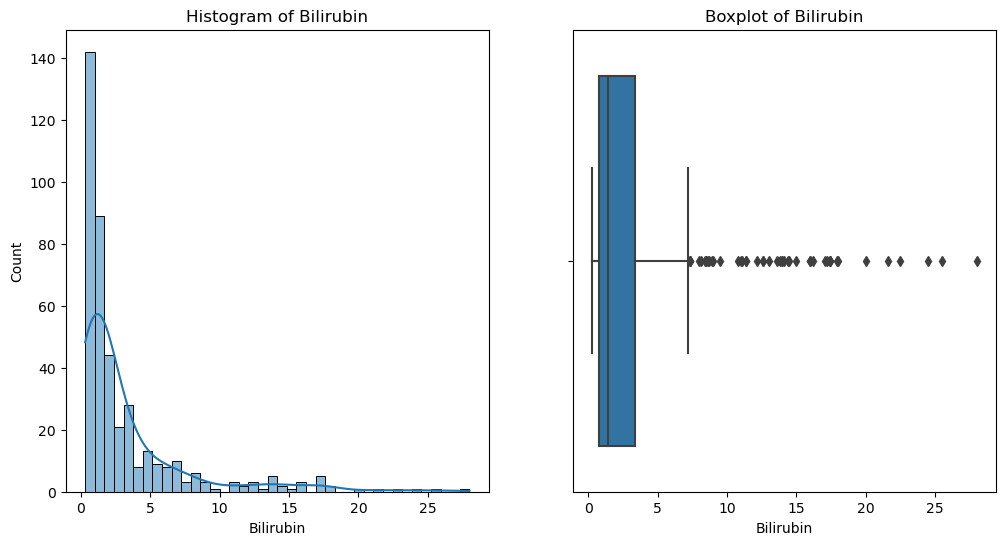

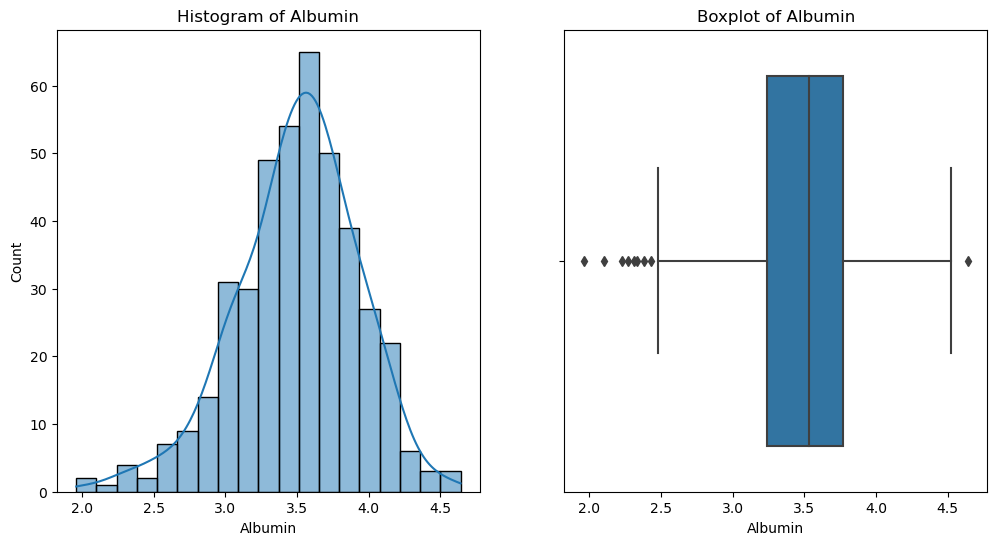

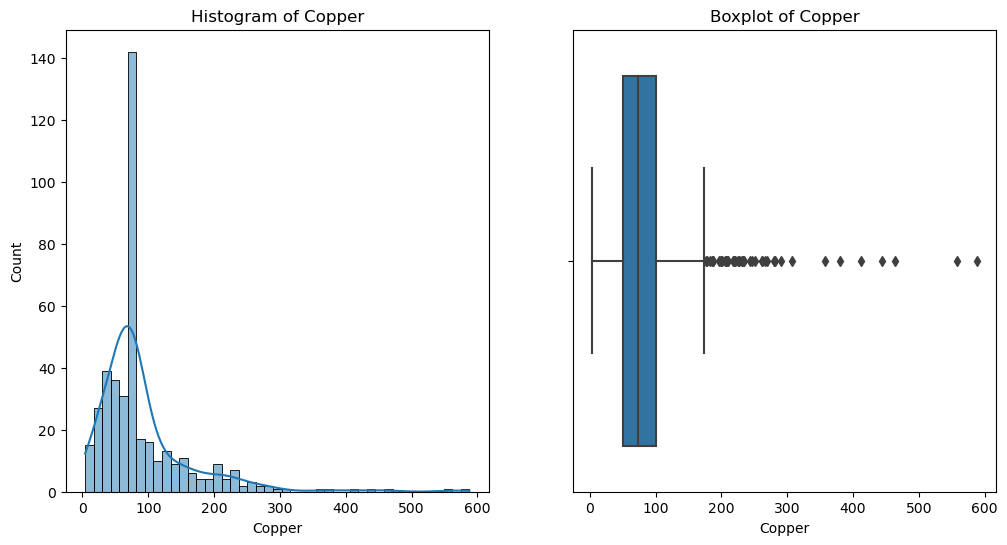

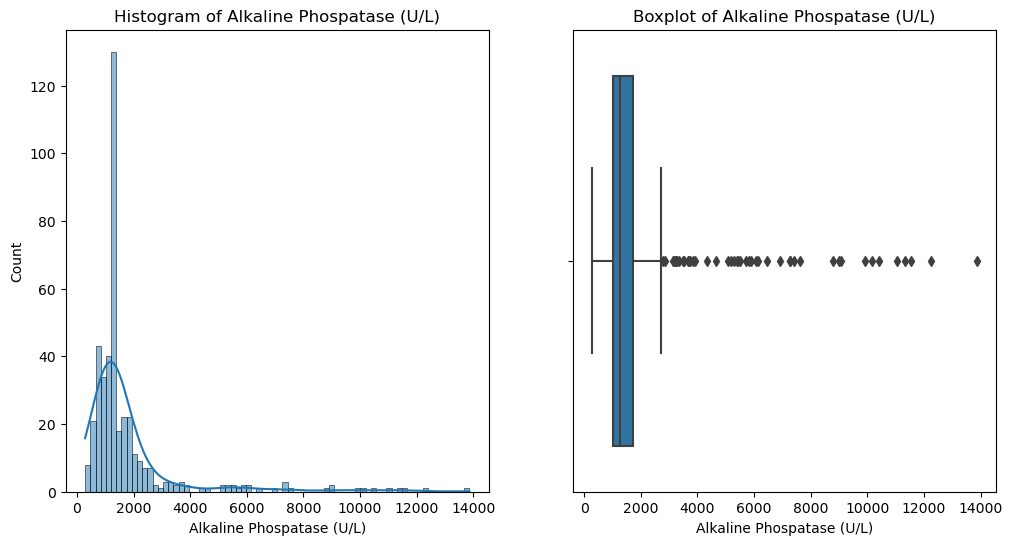

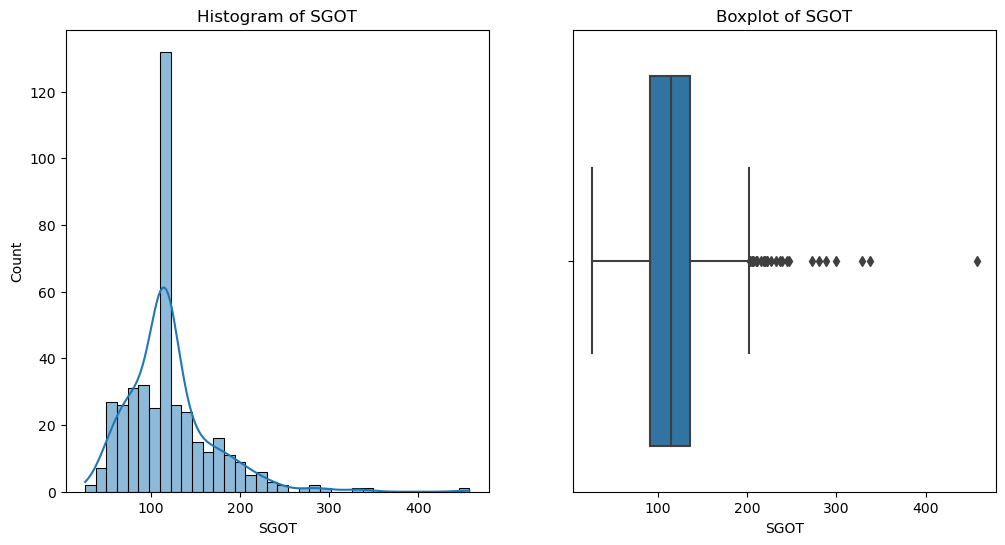

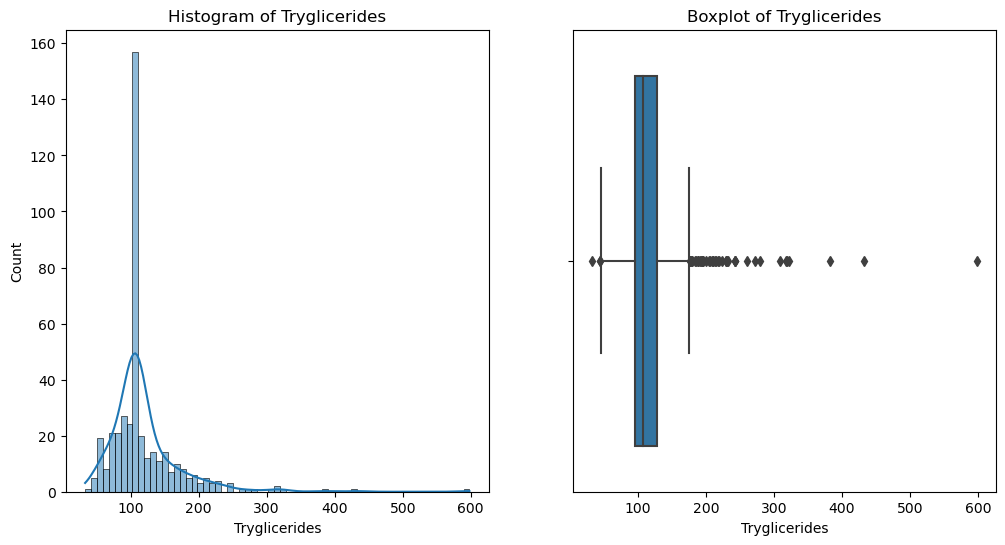

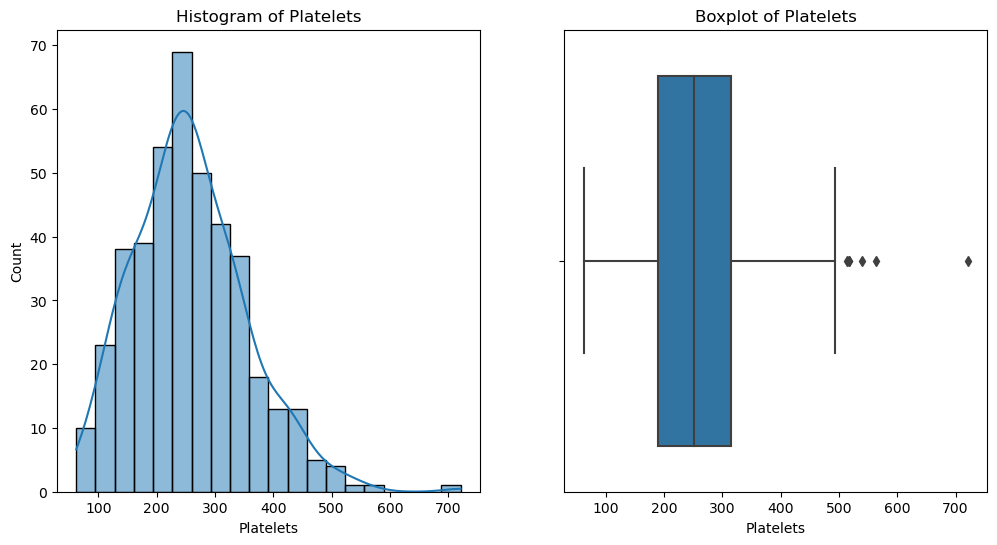

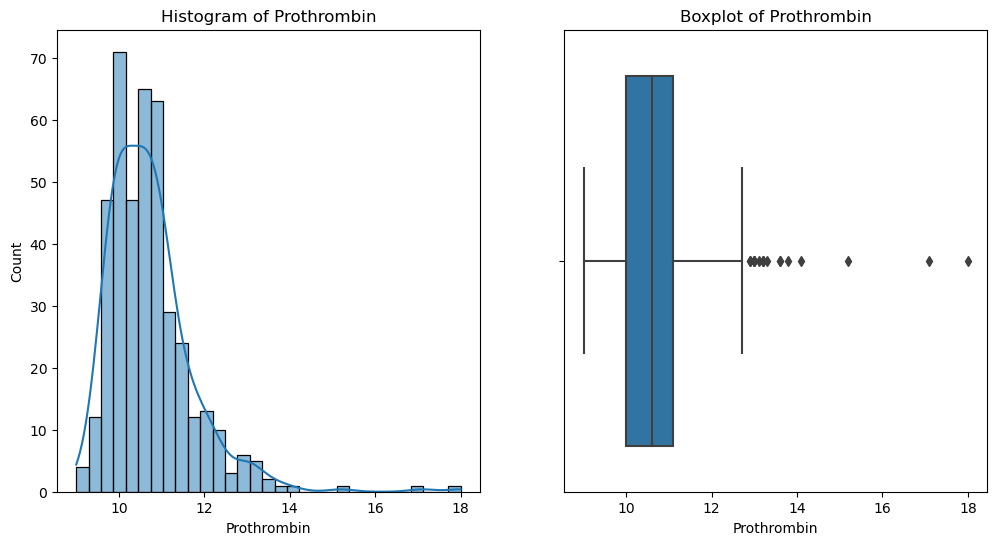

In [10]:
# ANALISIS DISTRIBUSI NUMERICAL
# Daftar variabel numerik
numerical_vars = ['Bilirubin', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Histogram dan boxplot untuk setiap variabel numerik
for var in numerical_vars:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[var], kde=True)
    plt.title(f'Histogram of {var}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot of {var}')
    
    plt.show()

1. **Bilirubin**:
   - Distribusi data sangat positif skewed dengan nilai outlier di atas 10.
   - Sebagian besar nilai berada di bawah 5.

2. **Albumin**:
   - Distribusi mendekati normal dengan beberapa outlier di bawah 3 dan di atas 4.5.
   - Sebagian besar nilai terkonsentrasi antara 3.5–4.

3. **Copper**:
   - Distribusi positif skewed dengan banyak outlier di atas 200.
   - Nilai terkonsentrasi di bawah 100.

4. **Alkaline Phosphatase (ALP)**:
   - Distribusi sangat skewed dengan outlier di atas 2000.
   - Sebagian besar data berada di bawah 1000.

5. **SGOT**:
   - Distribusi skewed dengan banyak outlier di atas 200.
   - Sebagian besar nilai berada di kisaran 100–150.

6. **Triglycerides**:
   - Distribusi skewed dengan nilai outlier di atas 200.
   - Sebagian besar data terkonsentrasi di sekitar 100–150.

7. **Platelets**:
   - Distribusi mendekati normal dengan beberapa outlier di atas 450.
   - Sebagian besar data berada di kisaran 200–300.

8. **Prothrombin**:
   - Distribusi positif skewed dengan outlier di atas 13.
   - Sebagian besar nilai berada di kisaran 10–12.

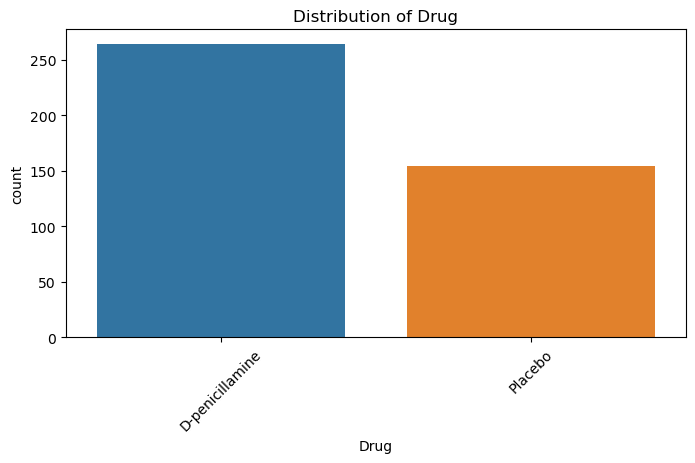

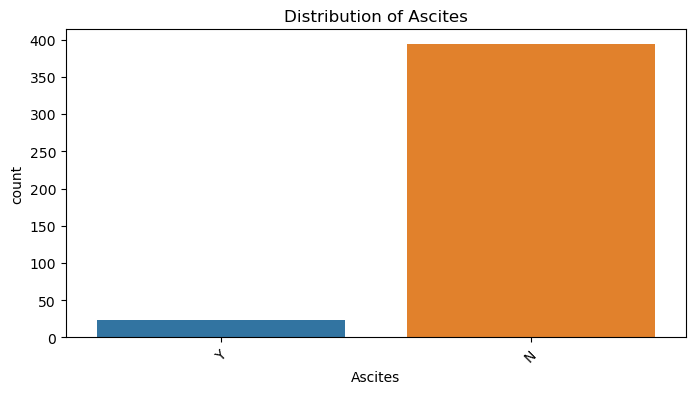

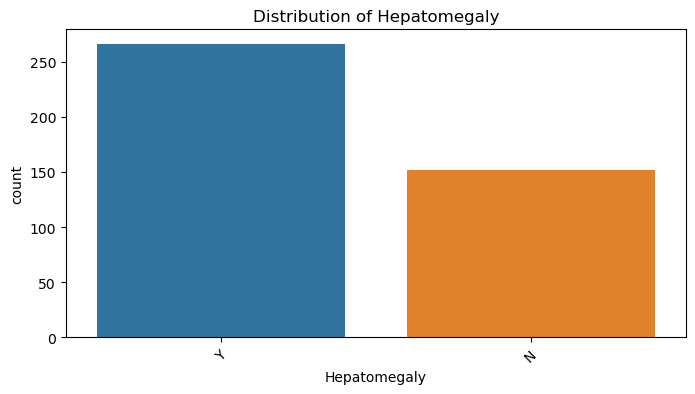

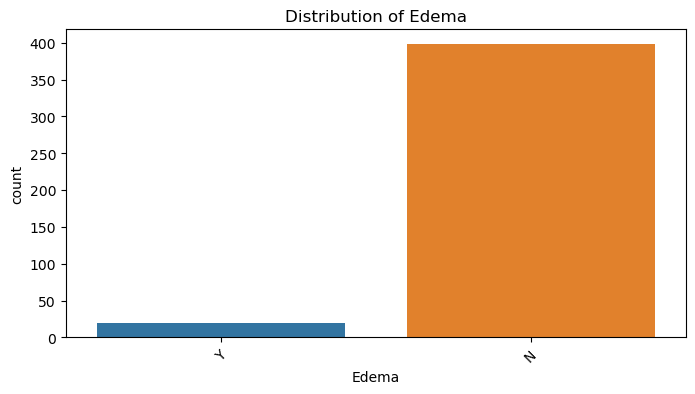

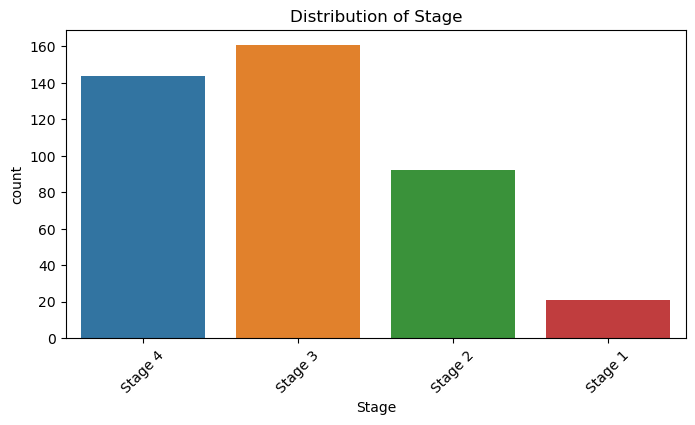

In [11]:
# VISUALISASI DATA KATEGORIKAL
# Daftar variabel kategorikal
categorical_vars = ['Drug', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']

# Bar chart untuk setiap variabel kategorikal
for var in categorical_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=var, data=df)
    plt.title(f'Distribution of {var}')
    plt.xticks(rotation=45)
    plt.show()

### 1. **Distribusi Obat (Drug)**
- Mayoritas pasien menggunakan **D-penicillamine** dibandingkan **Placebo**. Ini menunjukkan pengobatan aktif lebih sering digunakan daripada kontrol.

### 2. **Distribusi Ascites**
- Sebagian besar pasien tidak memiliki ascites (N). 
- Hanya sebagian kecil pasien yang memiliki ascites (Y). 

### 3. **Distribusi Hepatomegaly**
- Lebih banyak pasien yang memiliki hepatomegaly (T) dibandingkan yang tidak (N).

### 4. **Distribusi Edema**
- Mayoritas pasien tidak memiliki edema (N)

### 5. **Distribusi Stage**
- Sebagian besar pasien berada di **Stage 3** dan **Stage 4**, menunjukkan penyakit yang sudah pada tahap lanjut.
- Pasien di **Stage 1** sangat sedikit.

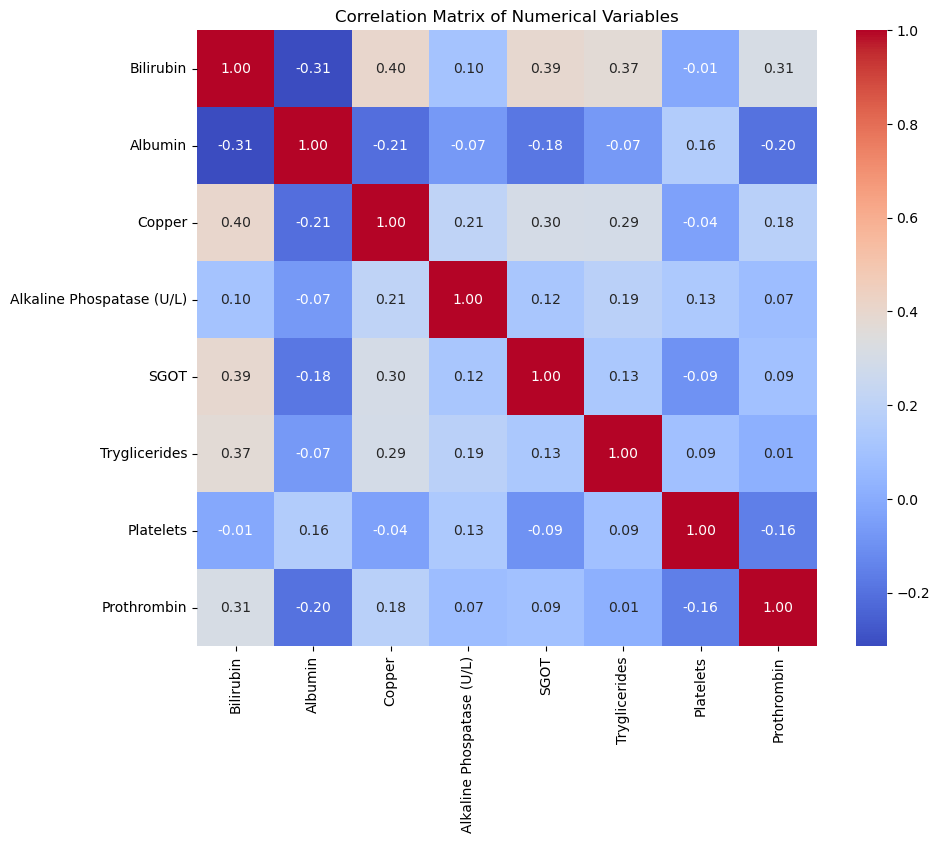

In [12]:
# ANALISIS KORELASI ANTARA VARIABEL NUMERIK
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

1. **Korelasi Positif yang Signifikan:**
   - **Bilirubin & Copper (0.40):** Terdapat hubungan positif moderat antara kedua variabel ini. Kenaikan kadar Bilirubin dapat diikuti oleh kenaikan kadar Copper.
   - **SGOT & Bilirubin (0.39):** Keduanya memiliki korelasi positif moderat, yang dapat menunjukkan hubungan fungsional (misalnya, dalam penilaian fungsi hati).
   - **Triglycerides & Copper (0.29):** Hubungan positif moderat antara kadar Trigliserida dan Copper.

2. **Korelasi Negatif yang Signifikan:**
   - **Albumin & Bilirubin (-0.31):** Hubungan negatif moderat, menunjukkan bahwa jika kadar Bilirubin meningkat, kadar Albumin cenderung menurun.
   - **Prothrombin & Albumin (-0.20):** Hubungan negatif rendah, menunjukkan sedikit keterkaitan antara keduanya.

3. **Korelasi Rendah atau Tidak Signifikan:**
   - Korelasi rendah antara **Platelets** dengan semua variabel lain, menunjukkan bahwa Platelets mungkin tidak memiliki hubungan langsung yang kuat dengan variabel lainnya dalam dataset ini.
   - **Alkaline Phosphatase (U/L)** juga memiliki korelasi rendah dengan sebagian besar variabel.

In [13]:
# Encode categorical
encoder = LabelEncoder()
categorical_columns = ['Drug', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

In [14]:
# Buat variabel baru AGE dari Birth Date
from datetime import datetime
current_year = datetime.now().year
df['Age'] = current_year - pd.to_datetime(df['Birth Date']).dt.year

# Drop the 'Birth Date' column
df.drop(columns=['Birth Date'], inplace=True)

In [28]:
# Splitting data
X = df.drop(columns=['ID', 'Registration Date', 'Stage'])  # Fitur
y = df['Stage']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Grid Search
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)

# Best Random Forest Model
print("Best Random Forest Parameters:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_

# XGBoost Grid Search
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train)

# Best XGBoost Model
print("Best XGBoost Parameters:", xgb_grid.best_params_)
xgb_best = xgb_grid.best_estimator_

# Evaluate Models
rf_y_pred = rf_best.predict(X_test)
xgb_y_pred = xgb_best.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_y_pred, zero_division=0))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_y_pred, zero_division=0))

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.27      0.16      0.20        19
           2       0.41      0.66      0.51        32
           3       0.73      0.55      0.63        29

    accuracy                           0.48        84
   macro avg       0.35      0.34      0.33        84
weighted avg       0.47      0.48      0.45        84


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.20      0.11      0.14        19
           2       0.43      0.66      0.52        32
           3       0.75      0.62      0.68        29

    accuracy                           0.50

### **Interpretasi Hasil Evaluasi Random Forest dan XGBoost**

#### **1. Best Parameters**
- **Random Forest**:
  - **`max_depth=10
  - **`min_samples_split=5
  - **`n_estimators=300`
- **XGBoost**:
  - **`learning_rate=0.01`
  - **`max_depth=3`
  - **`n_estimators=300`

#### **2. Random Forest Metrics**
- **Accuracy (48%)**: Model memprediksi benar hampir setengah dari total data uji.
- **Precision & Recall**:
  - **Kelas 2 dan 3** memiliki precision dan recall tertinggi, menunjukkan model lebih efektif menangani kelas mayoritas.
  - **Kelas 0 dan 1** memiliki metrik rendah, artinya model kesulitan memprediksi kelas dengan sampel lebih sedikit.
- **F1-Score**:
  - **Kelas 3 (0.63)** dan **Kelas 2 (0.51)** menunjukkan model cukup baik pada kelas mayoritas.
  - **Kelas 0 (0.0)** tidak terprediksi sama sekali.

#### **3. XGBoost Metrics**
- **Accuracy (50%)**: Sedikit lebih baik dibanding Random Forest.
- **Precision & Recall**:
  - **Kelas 0** memiliki precision tinggi (1.0), tetapi recall rendah (0.25), menunjukkan model hanya memprediksi beberapa instance dengan benar.
  - **Kelas 2 dan 3** memiliki metrik lebih baik dibanding kelas lain, dengan recall tinggi (0.66 untuk kelas 2 dan 0.62 untuk kelas 3).
- **F1-Score**:
  - **Kelas 3 (0.68)** dan **Kelas 2 (0.52)** menunjukkan performa lebih baik untuk kelas mayoritas.

In [23]:
print("\nRandom Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, rf_y_pred))
print("Precision:", precision_score(y_test, rf_y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, rf_y_pred, average='weighted'))

print("\nXGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test, xgb_y_pred))
print("Precision:", precision_score(y_test, xgb_y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, xgb_y_pred, average='weighted'))


Random Forest Metrics:
Accuracy: 0.47619047619047616
Precision: 0.469633307868602
Recall: 0.47619047619047616

XGBoost Metrics:
Accuracy: 0.5
Precision: 0.5150510204081632
Recall: 0.5


1. **Random Forest**:
   - **Akurasi (47.6%)**: Model memprediksi benar sekitar 47.6% dari total data uji.
   - **Precision (46.9%)**: Dari semua prediksi positif, hanya 46.9% yang benar-benar relevan.
   - **Recall (47.6%)**: Model berhasil menangkap 47.6% dari semua instance yang relevan.

   **Kesimpulan**: Model Random Forest memiliki performa sedang, dengan precision dan recall hampir sama, menunjukkan bahwa model tidak condong ke underfitting atau overfitting.

2. **XGBoost**:
   - **Akurasi (50%)**: Model memprediksi benar setengah dari total data uji.
   - **Precision (51.5%)**: Prediksi positif XGBoost lebih tepat dibanding Random Forest.
   - **Recall (50%)**: XGBoost menangkap separuh instance yang relevan.

   **Kesimpulan**: XGBoost lebih baik dibanding Random Forest dalam precision dan akurasi


Feature Importances (XGBoost):
                      Feature  Importance
12                Prothrombin    0.161140
3                Hepatomegaly    0.120444
2                     Ascites    0.099682
6                     Albumin    0.087886
5                   Bilirubin    0.087597
8   Alkaline Phospatase (U/L)    0.074775
7                      Copper    0.074020
10              Tryglicerides    0.070998
13                        Age    0.070305
11                  Platelets    0.067309
9                        SGOT    0.059331
4                       Edema    0.026514
0                        Drug    0.000000
1                      Gender    0.000000


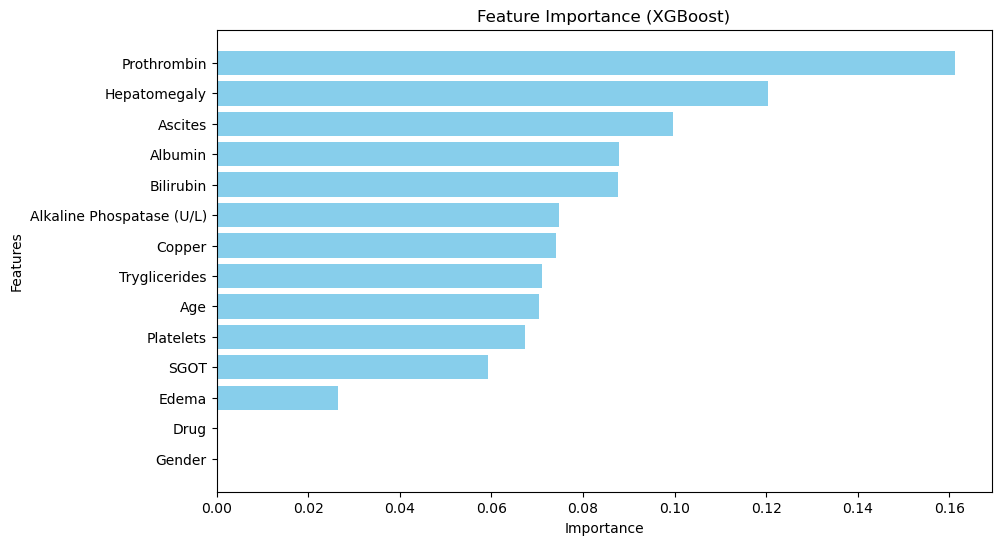

In [27]:
# Feature Importances for XGBoost
feature_importances = xgb_best.feature_importances_
feature_names = X.columns

# Combine feature names and importances into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance descending
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (XGBoost):")
print(importance_df)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Reverse the order to have the highest at the top
plt.show()

1. **Fitur Utama**:
   - **Prothrombin**, **Hepatomegaly**, dan **Ascites** adalah fitur paling penting dalam model, menunjukkan kontribusi signifikan terhadap prediksi.

2. **Fitur Menengah**:
   - **Albumin**, **Bilirubin**, dan **Alkaline Phosphatase** memiliki pengaruh moderat, relevan tetapi tidak sebesar fitur utama.

3. **Fitur Tidak Relevan**:
   - **Drug** dan **Gender** memiliki importance **0.0**, artinya tidak berkontribusi dalam model. Fitur ini dapat dihilangkan.